**Importing Libraries**

In [ ]:
#Imports for the project
import os
import keras
import tensorflow as tf
from datetime import datetime, timedelta
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler
model = keras.Sequential()

In [65]:
input_data = pd.read_csv('DanishFinalData.csv')
input_data = input_data.iloc[::-1]
# getting bolus data from final data file input
data_bolus_value=input_data['Value Bolus'].to_numpy()
# getting cgm data from final data file input
data_cgm_value = input_data['Value CGM'].to_numpy()
# total cgm data is the cgm data where bolus data is more than zero
total_data_cgm = data_cgm_value[data_bolus_value > 0]

Text(0.5, 1.0, 'CGM data Bar Graph')

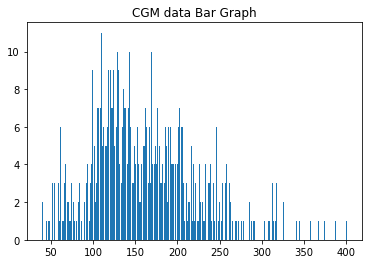

In [66]:
plt.bar(list(Counter(total_data_cgm).keys()), list(Counter(total_data_cgm).values()))
plt.title('CGM data Bar Graph')

In [67]:
# getting data which is in range after given timeshift
def function_timeshift(given_data, time_stamps, shift):
    data = pd.DataFrame(given_data)
    column = [data.shift(i) for i in range(time_stamps, -1*shift, -1)]
    data = pd.concat(column, axis=1)
    data.columns = list(range(0, len(data.columns)))
    data = data.dropna(how='any', axis=0)
    return data.to_numpy()

In [68]:
#getting GRU static layer static features of the data
def function_static_features(given_data):
    data = pd.DataFrame(given_data)
    output = pd.DataFrame()
    output["std"] = data.std(axis=1)
    output['mean'] = data.mean(axis=1)
    output['mag'] = data.diff(axis=1).abs().mean(axis=1)
    output['high'] = data.max(axis=1)
    output['median']= data.median(axis=1)
    output['gfi'] = ((data.diff(axis=1)**2).mean(axis=1))**0.5
    output['iqr'] = data.quantile(0.75,axis=1)-data.quantile(0.25,axis=1)
    output['low'] = data.min(axis=1)
    output['cv'] = (output['std']*100) / output['mean']
    output['gcf'] = output['gfi'] / output['mean']
    return output.to_numpy()

In [69]:
def split_train_test(given_data, split_per=0.8):
    input_data = pd.DataFrame(given_data)
    train_size = int(len(input_data) * split_per)
    train, test = input_data.iloc[:train_size], input_data.iloc[train_size:]
    return train.to_numpy(), test.to_numpy()

In [70]:
def function_rescale(value, newscale=(-1,1), oldscale=(-100,100)):
    (new_min, new_max) = newscale
    (old_min, old_max) = oldscale
    new_value= (new_max-new_min)/(old_max-old_min)*(value-old_max)+new_max
    return new_value

In [52]:
def function_difference_moving(given_data, replace_na=False):
    input_data = pd.DataFrame(given_data)
    diff_X = input_data.diff(axis=1)
    if not replace_na:
        diff_X = diff_X.dropna(axis=1)
    else:
        diff_X = diff_X.fillna(0.0)
    return diff_X.to_numpy()

In [71]:
def r_square(y_true, y_pred):
    from keras import backend as K 
    SS_total = K.sum(K.square(y_true - K.mean(y_true)))
    SS_result =  K.sum(K.square(y_true - y_pred)) 
    return ( 1 - SS_result/(SS_total + K.epsilon()) )

In [72]:
shift=4
time_stamps = 100
rnn_data_value = pd.DataFrame(function_timeshift(data_cgm_value, time_stamps, shift))
print(rnn_data_value)

         0      1      2      3      4      5      6      7      8      9    \
0      314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0   
1      314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0   
2      314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0   
3      314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0   
4      314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0  314.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
34993   90.0  101.0  115.0  129.0   79.0   69.0   49.0   49.0   49.0   49.0   
34994  101.0  115.0  129.0   79.0   69.0   49.0   49.0   49.0   49.0   49.0   
34995  115.0  129.0   79.0   69.0   49.0   49.0   49.0   49.0   49.0   73.0   
34996  129.0   79.0   69.0   49.0   49.0   49.0   49.0   49.0   73.0   83.0   
34997   79.0   69.0   49.0   49.0   49.0   49.0   49.0   73.0   83.0   90.0   

       ...    94     95     96     97     98     99

In [73]:
static_data_value = pd.DataFrame(function_static_features(rnn_data_value.iloc[:,0:100].to_numpy()))
print(static_data_value)

                0       1         2      3      4          5       6     7  \
0      117.405685  201.19  6.393939  314.0  278.0  18.319554  241.25  43.0   
1      117.229284  199.11  6.464646  314.0  278.0  18.333058  241.25  43.0   
2      116.955132  197.11  6.545455  314.0  221.0  18.350680  241.25  43.0   
3      116.638722  195.12  6.555556  314.0  151.0  18.350956  241.25  43.0   
4      116.287058  193.13  6.555556  314.0  136.0  18.350956  241.25  43.0   
...           ...     ...       ...    ...    ...        ...     ...   ...   
34993   39.151630  130.28  5.383838  194.0  147.0   9.565827   54.75  49.0   
34994   38.939705  130.68  5.343434  194.0  147.0   9.527737   54.25  49.0   
34995   38.825269  130.95  5.222222  194.0  147.0   9.425412   52.00  49.0   
34996   38.794005  131.07  5.090909  194.0  147.0   9.320337   52.00  49.0   
34997   38.796782  131.04  4.595960  194.0  147.0   7.850240   52.00  49.0   

               8         9  
0      58.355626  0.091056  
1    

In [74]:
train_X, test_X = split_train_test(static_data_value.to_numpy())
train_GRU, test_GRU = split_train_test(rnn_data_value.to_numpy())

In [75]:
test_GRU = function_difference_moving(test_GRU, True)
train_GRU = function_difference_moving(train_GRU, True)

In [76]:
test_GRU = np.vectorize(function_rescale)(test_GRU)
train_GRU = np.vectorize(function_rescale)(train_GRU)

In [77]:
X_test_GRU, test_Y = test_GRU[:,0:time_stamps], test_GRU[:,time_stamps:]
X_train_GRU, train_Y = train_GRU[:,0:time_stamps], train_GRU[:,time_stamps:]

In [78]:
scaler = StandardScaler()
scaler.fit(train_X,train_Y)
test_X = scaler.transform(test_X)
train_X = scaler.transform(train_X)
X_test_GRU = np.expand_dims(X_test_GRU, axis=-1)
X_train_GRU = np.expand_dims(X_train_GRU, axis=-1)
train_X = np.expand_dims(train_X, axis=-1)
test_X = np.expand_dims(test_X, axis=-1)

In [79]:
gru_input = layers.Input(shape=(X_train_GRU.shape[1], X_train_GRU.shape[2]))
static_input = layers.Input(shape=(train_X.shape[1], train_X.shape[2]))

gru_stack_1, gru_stack_1_c = layers.GRU(100, return_sequences=True, return_state=True)(gru_input)
drop_gru_1 = layers.Dropout(0.05)(gru_stack_1)

gru_stack_2, gru_stack_2_c = layers.GRU(100, return_sequences=True, return_state=True)(drop_gru_1)

static_dense = layers.Dense(2)(static_input)
static_flatten = layers.Flatten()(static_dense)

concatenate_data = layers.Concatenate()([gru_stack_1_c, gru_stack_2_c, static_flatten])


drop_2 = layers.Dropout(0.1)(concatenate_data)
dense_1 = layers.Dense(64)(drop_2)
drop_3 = layers.Dropout(0.05)(dense_1)  
dense_2 = layers.Dense(16)(drop_3)
drop_4 = layers.Dropout(0.02)(dense_2)

output_data = layers.Dense(4)(drop_4)


model = models.Model(inputs=[gru_input, static_input], outputs=output_data)
model.summary()
model.compile(loss='mse', optimizer='adam', metrics=[r_square,'mae'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
gru_2 (GRU)                     [(None, 100, 100), ( 30900       input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 100, 100)     0           gru_2[0][0]                      
____________________________________________________________________________________________

**Training the model**

In [80]:
filepath = "model_gru_static-{epoch:03d}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='r_square', verbose=1,
    save_best_only=False, save_weights_only=True, mode='auto', period=1)

history = model.fit(
    [X_train_GRU, train_X], train_Y,
    epochs=12,
    batch_size=60,
    verbose=1,
    validation_data=([X_test_GRU, test_X], test_Y),
    shuffle=True,
    callbacks=[checkpoint]
)

Epoch 1/12
467/467 [==============================] - 159s 319ms/step - loss: 0.0235 - r_square: -0.2133 - mae: 0.0804 - val_loss: 0.0190 - val_r_square: -0.0064 - val_mae: 0.0642

Epoch 00001: saving model to model_gru_static-001.h5
Epoch 2/12
467/467 [==============================] - 141s 302ms/step - loss: 0.0209 - r_square: 5.7528e-04 - mae: 0.0666 - val_loss: 0.0189 - val_r_square: 0.0043 - val_mae: 0.0635

Epoch 00002: saving model to model_gru_static-002.h5
Epoch 3/12
467/467 [==============================] - 149s 318ms/step - loss: 0.0191 - r_square: 0.0196 - mae: 0.0640 - val_loss: 0.0186 - val_r_square: 0.0166 - val_mae: 0.0641

Epoch 00003: saving model to model_gru_static-003.h5
Epoch 4/12
467/467 [==============================] - 160s 343ms/step - loss: 0.0193 - r_square: 0.0239 - mae: 0.0644 - val_loss: 0.0184 - val_r_square: 0.0345 - val_mae: 0.0634

Epoch 00004: saving model to model_gru_static-004.h5
Epoch 5/12
467/467 [==============================] - 169s 363ms/s

Text(0.5, 0, 'r val square')

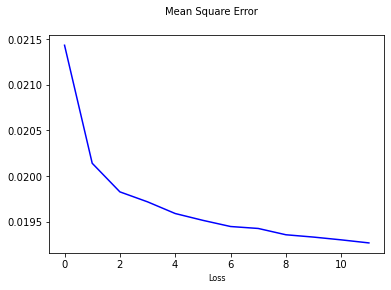

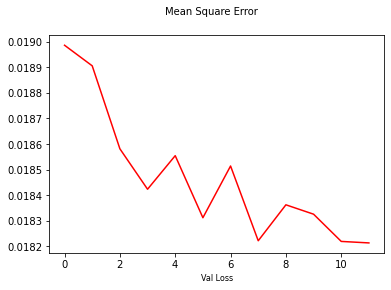

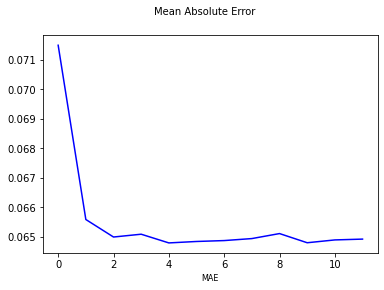

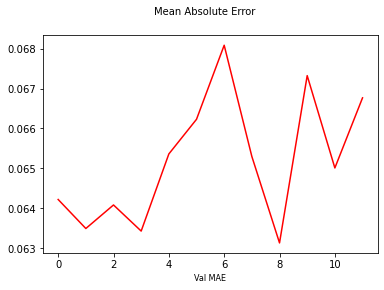

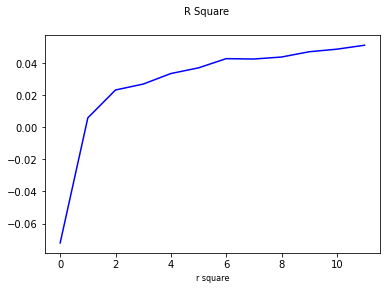

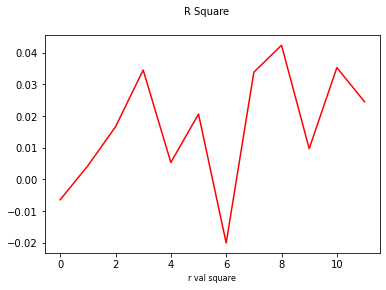

In [97]:
#Plotting results
fig =plt.figure()
plt.plot(history.history['loss'],color='blue')
fig.suptitle('Mean Square Error', fontsize=10)
plt.xlabel('Loss', fontsize=8)
fig =plt.figure()
plt.plot(history.history['val_loss'],color='red')
fig.suptitle('Mean Square Error', fontsize=10)
plt.xlabel('Val Loss', fontsize=8)

fig =plt.figure()
plt.plot(history.history['mae'],color='blue')
fig.suptitle('Mean Absolute Error', fontsize=10)
plt.xlabel('MAE', fontsize=8)
fig =plt.figure()
plt.plot(history.history['val_mae'],color='red')
fig.suptitle('Mean Absolute Error', fontsize=10)
plt.xlabel('Val MAE', fontsize=8)


fig =plt.figure()
plt.plot(history.history['r_square'],color='blue')
fig.suptitle('R Square', fontsize=10)
plt.xlabel('r square', fontsize=8)
fig =plt.figure()
plt.plot(history.history['val_r_square'],color='red')
fig.suptitle('R Square', fontsize=10)
plt.xlabel('r val square', fontsize=8)


**Predicting the values of the test data**

In [117]:
#Reshaping cgm data to (1, 399)
cgm_data_testing = data_cgm_value[-400:-1]
cgm_data_testing = cgm_data_testing.reshape(1, 399)

time_stamps = 100
ahead_pred = 100
prediction_Y = []

In [118]:

long_short_tm_org = cgm_data_testing[:,0:time_stamps]
ground_Y = cgm_data_testing[:,time_stamps:time_stamps+ahead_pred]

for i in range(ahead_pred):
    long_short_tm_data = function_difference_moving(long_short_tm_org, replace_na=True)
    long_short_tm_data = np.vectorize(function_rescale)(long_short_tm_data)
    
    input_static = get_static_features(long_short_tm_org)
    input_static = scaler.transform(input_static)
    
    long_short_tm_data = np.expand_dims(long_short_tm_data, axis=-1)
    input_static = np.expand_dims(input_static, axis=-1)

    prediction = model.predict([long_short_tm_data, input_static])
    prediction = prediction[0][0]
    prediction = function_rescale(prediction, newscale=(-100,100), oldscale=(-1,1))
    prediction = long_short_tm_org[:,-1]+prediction    
    if prediction > int(prediction)+0.5:
         prediction = int(prediction)+1.0
    else:
         prediction = int(prediction)+0.0
    print(prediction)
    prediction_Y.append(prediction)
    prediction = np.reshape(prediction, (1,1))
    long_short_tm_org = np.concatenate((long_short_tm_org[:,1:], prediction), axis=-1)

    

107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
145.0
145.0
145.0
145.0
145.0
145.0
145.0
145.0
145.0
145.0
145.0
145.0
145.0
145.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
154.0
154.0
154.0
154.0
154.0
154.0
154.0
154.0
154.0
153.0
152.0
151.0
150.0
149.0
148.0
147.0
146.0
145.0
144.0
143.0
142.0
141.0
140.0
139.0
138.0
137.0
136.0
135.0
134.0
133.0
132.0
131.0
130.0
129.0
128.0
127.0
126.0


In [119]:
prediction_Y = np.array(prediction_Y)
prediction_Y = prediction_Y.reshape((1, 100))
print("prediction_Y: ",prediction_Y)
prediction_Y.shape
print("ground_Y: ",ground_Y)
ground_Y.shape
#Threshold is 60
thresh =60
c=0
for i in range(len(prediction_Y[0])):
    if abs(prediction_Y[0][i]-ground_Y[0][i])<thresh:
        c+=1

#Accuracy of the prediction        
accuracy  = c/len(prediction_Y[0])*100
print('\n')
print("Accuracy:",accuracy)

prediction_Y:  [[107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120.
  121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134.
  135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 145. 145. 145.
  145. 145. 145. 145. 145. 145. 145. 145. 145. 145. 145. 145. 146. 147.
  148. 149. 150. 151. 152. 153. 154. 154. 154. 154. 154. 154. 154. 154.
  154. 154. 153. 152. 151. 150. 149. 148. 147. 146. 145. 144. 143. 142.
  141. 140. 139. 138. 137. 136. 135. 134. 133. 132. 131. 130. 129. 128.
  127. 126.]]
ground_Y:  [[108. 108. 110. 108. 108. 108. 103.  93.  95.  97.  97.  97. 100. 105.
  106. 106.  84.  70.  62. 131. 131. 131. 131. 131. 140. 144. 144. 150.
  141. 126. 114. 115.  86.  92.  75.  75.  70.  72.  72.  72.  69.  69.
   69.  63.  63.  67.  67.  70.  70.  69.  65.  62.  63.  63.  63.  63.
   63.  60.  60.  57. 104. 110. 110. 110. 110. 110. 110. 110. 126. 133.
  135. 141. 144. 137. 137. 137. 148. 148. 147. 135. 136. 136. 142. 168.
  168. 174. 207. 209. 20